In [2]:
import copy

import numpy as np
import matplotlib.pyplot as plt

import qibo
from qibo import hamiltonians, optimizers, gates

from qibo.models.dbi.double_bracket import (
    DoubleBracketIteration,
    DoubleBracketGeneratorType,
)

from boostvqe.ansatze import VQE, hw_preserving
from boostvqe.utils import rotate_h_with_vqe

In [20]:
qibo.set_backend("qiboml", platform="tensorflow")
plt.set_loglevel('WARNING') 

[Qibo 0.2.14|INFO|2024-11-29 14:22:12]: Using qiboml (tensorflow) backend on /device:CPU:0
INFO:qibo.config:Using qiboml (tensorflow) backend on /device:CPU:0


#### Some plotting functions

In [21]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_vqe_states(state, state2=None):
    """
    Plot `state` and `state2` if provided. 
    """
    n = int(np.log2(len(state)))
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)] 
    
    plt.figure(figsize=(12,4))
    for i, amp in enumerate(state):
        if i == 0:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black", label="Ground state")
        else:
            plt.bar(bitstrings[i], np.abs(amp)**2, color='#C194D8', alpha=0.7, edgecolor="black")
    if state2 is not None:     
        for i, amp in enumerate(state2):
            if i == 0:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none", label="VQE approximation")
            else:
                plt.bar(bitstrings[i], np.abs(amp)**2, color='black', alpha=1, edgecolor="black", hatch="\\\\", facecolor="none")
                
    plt.xticks(ticks=range(len(bitstrings)), labels=bitstrings, rotation=90)
    plt.xlabel("Components")
    plt.ylabel("Probabilities")
    plt.title("State representation")
    plt.legend()
    plt.show()

def plot_loss(loss_history, vqe):
    target_gs_energy = np.min(np.array(np.real(vqe.hamiltonian.eigenvalues())))
    plt.figure(figsize=(6, 6 * 6 / 8))
    plt.plot(loss_history, color="purple", label="Loss history", lw=1.5, alpha=0.7)
    plt.hlines(target_gs_energy, 0, len(loss_history), color="black", label="Target GS energy", lw=1.5, alpha=0.7, ls="--")
    plt.legend()
    plt.show()

#### Problem setup

In [35]:
nqubits = 6
nlayers = 3

In [36]:
# Build circuit
circuit = hw_preserving(nqubits=nqubits, nlayers=nlayers)
circuit.draw()

# We save a copy of the circuit for later
backup_circ = circuit.copy(deep=True)

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─


In [37]:
# Initial parameters are zeros
default_params = circuit.get_parameters()
nparams = len(default_params)
print(f" Default params: {default_params}\n nparams: {nparams}")

 Default params: [(0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,), (0.0,)]
 nparams: 33


In [38]:
# Build input Hamiltonian
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5)
ground_state = h0.ground_state()
gs_energy = np.min(np.real(h0.eigenvalues()))

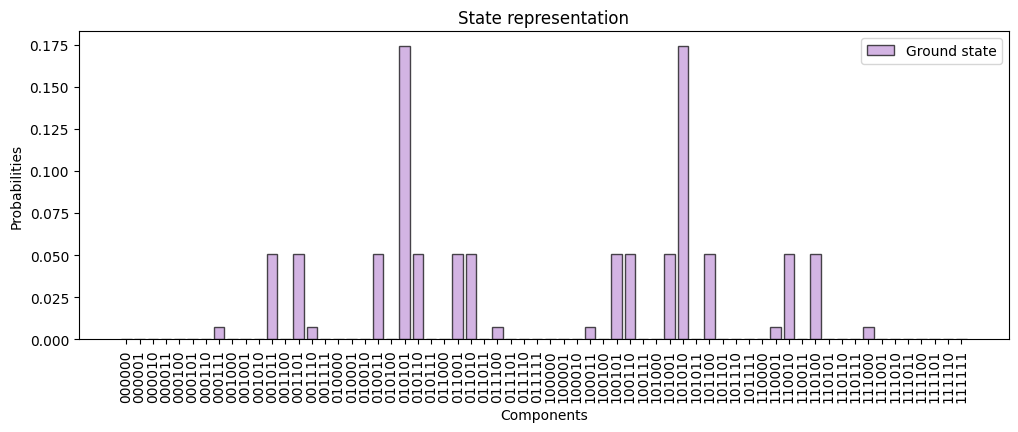

In [39]:
plot_vqe_states(ground_state)

In [40]:
# Initialize VQE object
vqe = VQE(circuit=circuit, hamiltonian=copy.deepcopy(h0))

#### Train the VQE

In [41]:
# Set initial params
initial_parameters  = np.random.normal(0., 0.5, nparams)

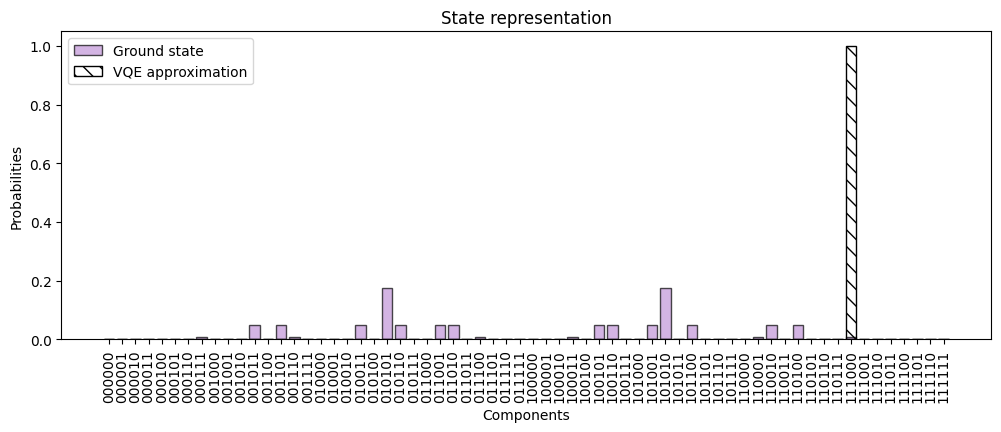

In [42]:
# VQE ground state before setting initial parameters
plot_vqe_states(ground_state, vqe.circuit().state())

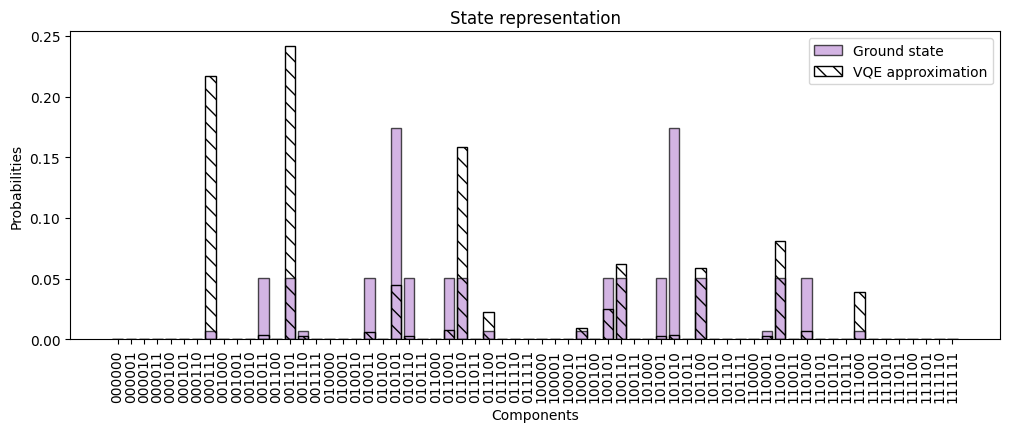

In [43]:
vqe.circuit.set_parameters(initial_parameters)
plot_vqe_states(ground_state, vqe.circuit().state())

##### Defining some callbacks to keep track during optimization

In [44]:
loss_history, params_history = [], []

def tracker_function(
    params, 
    vqe=vqe, 
    loss_history=loss_history,
    params_history=params_history,
):
    """Keep track of loss function and VQE params history during the optimization."""
    vqe.circuit.set_parameters(params)
    loss_history.append(
        vqe.hamiltonian.expectation(
            vqe.circuit().state()
        )
    )
    params_history.append(params)
    print(f"Execution iteration {len(loss_history)} \t Loss: {loss_history[-1]}")

In [45]:
optimizer_options = {
    "nepochs" : 50,
    "method": "Adam",
    "nmessage": 1,
    "learning_rate": 0.05,
}

opt_results = vqe.minimize(
    initial_parameters, 
    method="sgd", 
    options=optimizer_options,
    callback=tracker_function
)

Execution iteration 1 	 Loss: -1.2689964426460874
Execution iteration 2 	 Loss: -2.0873524558607137
Execution iteration 3 	 Loss: -2.7918883422545595
Execution iteration 4 	 Loss: -3.4550078866298657
Execution iteration 5 	 Loss: -4.0765836558307385
Execution iteration 6 	 Loss: -4.653509310002628
Execution iteration 7 	 Loss: -5.180259621714342
Execution iteration 8 	 Loss: -5.649718052880595
Execution iteration 9 	 Loss: -6.0544151615900486
Execution iteration 10 	 Loss: -6.3917791363752405
Execution iteration 11 	 Loss: -6.666487538434719
Execution iteration 12 	 Loss: -6.887851640343939
Execution iteration 13 	 Loss: -7.06661635404966
Execution iteration 14 	 Loss: -7.212945284476339
Execution iteration 15 	 Loss: -7.3354596344965515
Execution iteration 16 	 Loss: -7.440953190432779
Execution iteration 17 	 Loss: -7.5345034594488265
Execution iteration 18 	 Loss: -7.619768727077402
Execution iteration 19 	 Loss: -7.69932379618735
Execution iteration 20 	 Loss: -7.7749542805930325
E

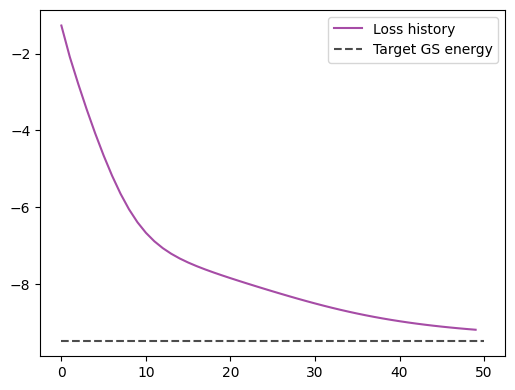

In [46]:
plot_loss(loss_history, vqe)

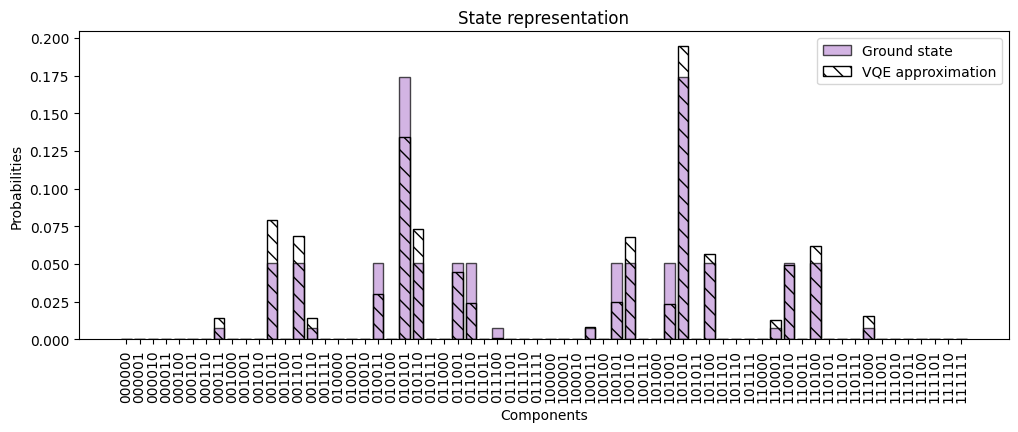

In [47]:
plot_vqe_states(ground_state, vqe.circuit().state())

#### Apply DBQA after warm start

In [48]:
rotated_h = rotate_h_with_vqe(hamiltonian=h0, vqe=vqe)

In [49]:
rotated_h = hamiltonians.Hamiltonian(nqubits=nqubits, matrix=rotated_h)

In [50]:
dbi = DoubleBracketIteration(
    hamiltonian=rotated_h,
    mode=DoubleBracketGeneratorType.single_commutator,
)

In [51]:
operators, energies = [], []
for _ in range(3):
    dbi_op = dbi(step=0.01, d=dbi.diagonal_h_matrix)
    zero_state = np.transpose([dbi.h.backend.zero_state(dbi.h.nqubits)])
    energies.append(dbi.h.expectation(zero_state))
    operators.append(dbi_op)

In [52]:
energies

[<tf.Tensor: shape=(), dtype=float64, numpy=-9.420546265619016>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.457911676970992>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-9.465210218133791>]

In [53]:
old_circ_matrix = vqe.circuit.unitary()

circ = backup_circ.copy(deep=True)
for gate in reversed([old_circ_matrix] + operators):
    circ.add(gates.Unitary(gate, *range(nqubits), trainable=False))

In [54]:
circ.draw()

0:     ─X─RBS─────────────────RBS─RBS─────────RBS─────RBS─────────────────RBS ...
1:     ─X─RBS─────────RBS─────|───|───────RBS─|───────RBS─────────RBS─────|── ...
2:     ─X─────RBS─────RBS─────|───RBS─────|───|───────────RBS─────RBS─────|── ...
3:     ───────RBS─────────RBS─|───────RBS─RBS─|───RBS─────RBS─────────RBS─|── ...
4:     ───────────RBS─────RBS─|───────|───────RBS─|───────────RBS─────RBS─|── ...
5:     ───────────RBS─────────RBS─────RBS─────────RBS─────────RBS─────────RBS ...

0: ... ─RBS─────────RBS─────RBS─────────────────RBS─RBS─────────RBS─────U─U─U ...
1: ... ─|───────RBS─|───────RBS─────────RBS─────|───|───────RBS─|───────U─U─U ...
2: ... ─RBS─────|───|───────────RBS─────RBS─────|───RBS─────|───|───────U─U─U ...
3: ... ─────RBS─RBS─|───RBS─────RBS─────────RBS─|───────RBS─RBS─|───RBS─U─U─U ...
4: ... ─────|───────RBS─|───────────RBS─────RBS─|───────|───────RBS─|───U─U─U ...
5: ... ─────RBS─────────RBS─────────RBS─────────RBS─────RBS─────────RBS─U─U─U ...

0: ... ─U─
1: 

In [55]:
circ.set_parameters(np.zeros(nparams))

In [56]:
vqe1 = VQE(hamiltonian=copy.deepcopy(h0), circuit=circ)

In [57]:
vqe1.circuit().state()

<tf.Tensor: shape=(64,), dtype=complex128, numpy=
array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])>